# *(Joglekar, et. al, 2018)*: Inter-areal Balanced Amplification taichi customized operators

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/examples/blob/main/large_scale_modeling/Joglekar_2018_InterAreal_Balanced_Amplification_taichi_customized_op.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/examples/blob/main/large_scale_modeling/Joglekar_2018_InterAreal_Balanced_Amplification_taichi_customized_op.ipynb)

Using taichi customized operators to implement the model in *(Joglekar, et. al, 2018)*.:

- Joglekar, Madhura R., et al. "Inter-areal balanced amplification enhances signal propagation in a large-scale circuit model of the primate cortex." Neuron 98.1 (2018): 222-234.

In [50]:
import brainpy as bp
import brainpy.math as bm
from brainpy import neurons


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from typing import Tuple, Optional
from functools import partial

In [51]:
bp.__version__

'2.5.0'

In [52]:
# You should import taichi before customize your operators 
import taichi as ti
''' 
And there are some random number generators 
which were defined in BrainPy,
We need to use these in taichi kernels
'''
from brainpy.math.tifunc import (lfsr88_key, lfsr88_random_integers)

In [53]:
# You can select the target platform you want to run your customized operators
# bm.set_platform('cpu')
bm.set_platform('gpu')

# Define the kernel with taichi.kernel decorater

For customized your operators, you can find the tutorial at [CPU and GPU Operator Customization with Taichi](https://brainpy.tech/docs/tutorial_advanced/operator_custom_with_taichi.html)

In [54]:
# Define a Taichi kernel for processing multiple areas with event-driven updates on the CPU.
# This kernel updates an output array based on event occurrences, weights, and a random distribution.
@ti.kernel
def _multiple_area_event_mv_prob_homo_irregular_cpu_E(
        events: ti.types.ndarray(ndim=1),  # 1D array of events, where nonzero values indicate a spike.
        weight: ti.types.ndarray(ndim=1),  # 1D array of weights, one per area, to be added to the output on an event.
        clen: ti.types.ndarray(ndim=1),    # 1D array containing the upper limit for random integer generation.
        seed: ti.types.ndarray(ndim=1),    # 1D array of seeds, one per area, for random number generation.
        out: ti.types.ndarray(ndim=2)      # 2D output array where current updates are made based on events and weights.
):
    num_row = out.shape[1]  # Number of rows in the output array.
    num_col = events.shape[0]  # Number of columns (events) to process.
    clen0 = clen[0]  # Upper limit for random integer generation.

    for i_col in range(num_col):  # Iterate over each event.
        if events[i_col] != 0.:  # Check if the current event occurred (nonzero).
            for i_area in range(out.shape[0]):  # Iterate over each area.
                key = lfsr88_key(seed[i_area] + i_col)  # Generate an initial key for random numbers.
                key, i_row = lfsr88_random_integers(key, 0, clen0 - 1)  # Generate the first random row index.
                while i_row < num_row:  # Ensure the random index is within bounds.
                    out[i_area, i_row] += weight[i_area]  # Update the output array with the weight.
                    key, inc = lfsr88_random_integers(key, 1, clen0)  # Generate the next random increment.
                    i_row += inc  # Update the row index based on the random increment.

# GPU version, almost as same above kernel
@ti.kernel
def _multiple_area_event_mv_prob_homo_irregular_gpu_E(
        events: ti.types.ndarray(ndim=1),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[0]
    clen0 = clen[0]
    area_num = out.shape[0]
    
    # Due to the arch of GPU, use ti.ndrange for parallel processing across events and areas.
    for i_col, i_area in ti.ndrange(num_col, area_num):
        if events[i_col] != 0.:
            key = lfsr88_key(seed[i_area] + i_col)
            key, i_row = lfsr88_random_integers(key, 0, clen0 - 1)
            while i_row < num_row:
                out[i_area, i_row] += weight[i_area]
                key, inc = lfsr88_random_integers(key, 1, clen0)
                i_row += inc


@ti.kernel
def _multiple_area_event_mv_prob_homo_irregular_cpu_I(
        events: ti.types.ndarray(ndim=2), # 2D array of events, where nonzero values indicate a spike in a region .
        weight: ti.types.ndarray(ndim=1), # 1D array of weights, one per area, to be added to the output on an event.
        clen: ti.types.ndarray(ndim=1),   # 1D array containing the upper limit for random integer generation.
        seed: ti.types.ndarray(ndim=1),   # 1D array of seeds, one per area, for random number generation.
        out: ti.types.ndarray(ndim=2)     # 2D output array where current updates are made based on events and weights.
):
    num_row = out.shape[1] # Number of rows in the output array.
    num_col = events.shape[1] # Number of columns (events) to process.
    clen0 = clen[0] # Upper limit for random integer generation.
    weight0 = weight[0] # Each area has same weight

    for i_col in range(num_col): # Iterate over each event.
        for i_area in range(out.shape[0]): # Inhibitory neurons affect only those in their own region
            if events[i_area, i_col] != 0.: # Check if the current event occurred (nonzero).
                key = lfsr88_key(seed[i_area] + i_col) # Generate an initial key for random numbers.
                key, i_row = lfsr88_random_integers(key, 0, clen0 - 1) # Generate the first random row index.
                while i_row < num_row: # Ensure the random index is within bounds.
                    out[i_area, i_row] += weight0 # Update the output array with the weight.
                    key, inc = lfsr88_random_integers(key, 1, clen0) # Generate the next random increment.
                    i_row += inc # Update the row index based on the random increment.

# GPU version, almost as same above kernel
@ti.kernel
def _multiple_area_event_mv_prob_homo_irregular_gpu_I(
        events: ti.types.ndarray(ndim=1),
        weight: ti.types.ndarray(ndim=1),
        clen: ti.types.ndarray(ndim=1),
        seed: ti.types.ndarray(ndim=1),
        out: ti.types.ndarray(ndim=2)
):
    num_row = out.shape[1]
    num_col = events.shape[1]
    weight0 = weight[0]
    clen0 = clen[0]
    area_num = out.shape[0]

    # Due to the arch of GPU, use ti.ndrange for parallel processing across events and areas.
    for i_col, i_area in ti.ndrange(num_col, area_num):
        if events[i_area, i_col] != 0.:
            key = lfsr88_key(seed[i_area] + i_col)
            key, i_row = lfsr88_random_integers(key, 0, clen0 - 1)
            while i_row < num_row:
                out[i_area, i_row] += weight0
                key, inc = lfsr88_random_integers(key, 1, clen0)
                i_row += inc

# register taichi kernel in BrainPy
_multiple_area_event_mv_prob_homo_irregular_p_E = bm.XLACustomOp(cpu_kernel=_multiple_area_event_mv_prob_homo_irregular_cpu_E, 
                                                                        gpu_kernel=_multiple_area_event_mv_prob_homo_irregular_gpu_E)
_multiple_area_event_mv_prob_homo_irregular_p_I = bm.XLACustomOp(cpu_kernel=_multiple_area_event_mv_prob_homo_irregular_cpu_I, 
                                                                 gpu_kernel=_multiple_area_event_mv_prob_homo_irregular_gpu_I)

## Callable apis for further encapsulation and checking before call

In [55]:
def multiple_area_customized_op_E(
        events: jax.Array,  # Input events, expected to be a 1D array.
        weight: float,  # Uniform weight for all updates.
        seed: list[int],  # List of seeds for random number generation of each region
        conn_prob: float,  # Connection probability between events and areas.
        *,
        shape: Tuple[int, int],  # Shape of the output matrix.
        area_num: int,  # Number of areas (rows in the output matrix).
):
    # Convert inputs to JAX arrays for compatibility.
    events = bm.as_jax(events)
    if isinstance(weight, float): weight = bm.as_jax(weight)
    weight = jnp.atleast_1d(bm.as_jax(weight))

    # Calculate the connection length based on connection probability.
    conn_len = jnp.ceil(1 / conn_prob) * 2 - 1
    conn_len = jnp.asarray(jnp.atleast_1d(conn_len), dtype=jnp.int32)

    # Call the raw operation function with prepared inputs.
    return raw_multiple_area_customized_op_E(events, weight, conn_len, seed, shape=shape, area_num=area_num)[0]

    
def raw_multiple_area_customized_op_E(
        events: jax.Array,
        weight: jax.Array,  # Assumed to be a vector of size 1.
        conn_len: jax.Array,  # Connection length, a vector of size 1.
        seed: jax.Array,  # Seed for random number generation, a vector of size 1.
        *,
        shape: Tuple[int, int],  # Shape of the output matrix.
        area_num: int,  # Number of areas.
) -> jax.Array:
    # Perform various input validations to ensure correct types and shapes.
    assert events.dtype in [jnp.bool_, jnp.float16, jnp.float32, jnp.float64]

    if events.ndim != 1:
        raise ValueError('vector should be a 1D vector.')
    if len(shape) != 2:
        raise ValueError('shape should be a length-2 tuple.')
    if seed.ndim != 1:
        raise ValueError('seed must be a 1D scalar.')
    if conn_len.ndim != 1:
        raise ValueError('conn_prob must be a 1D scalar.')
    if type(area_num) != int:
        raise ValueError('area_num must be an integer')

    assert conn_len.dtype in [jnp.int16, jnp.int32, jnp.int64, jnp.uint16, jnp.uint32, jnp.uint64]
    assert seed.dtype in [jnp.int16, jnp.int32, jnp.int64, jnp.uint16, jnp.uint32, jnp.uint64]

    for value in tuple(weight):
        assert value.dtype in [jnp.float16, jnp.float32, jnp.float64], '"weight" must be float valued.'

    # Define the shape of the output matrix and verify shape compatibility.
    out_shape = (area_num, shape[1])
    if events.shape[0] != shape[0]:
        raise ValueError(f'Shape mismatch, vec {events.shape} @ mat {shape}.')
    shape = shape[::-1]

    # Call the primitive operation with validated inputs.
    prim = _multiple_area_event_mv_prob_homo_irregular_p_E
    return prim(events,
                weight,
                conn_len,
                seed,
                outs=[jax.ShapeDtypeStruct(shape=out_shape, dtype=weight.dtype)],
                shape=shape,
                area_num=area_num)    

def multiple_area_customized_op_I(
        events: jax.Array,  # Input events, expected to be a 2D array.
        weight: float,  # Uniform weight for all updates.
        seed: list[int], # List of seeds for random number generation of each region
        conn_prob: float,  # Connection probability.
        *,
        shape: Tuple[int, int],  # Shape of the output matrix.
        area_num: int,  # Number of areas.
):
    # Similar preparation and validation steps as in multiple_area_customized_op_E.
    events = bm.as_jax(events)
    if isinstance(weight, float): weight = bm.as_jax(weight)
    weight = jnp.atleast_1d(bm.as_jax(weight))
    conn_len = jnp.ceil(1 / conn_prob) * 2 - 1
    conn_len = jnp.asarray(jnp.atleast_1d(conn_len), dtype=jnp.int32)
    return raw_multiple_area_customized_op_I(events, weight, conn_len, seed, shape=shape, area_num=area_num)[0]


def raw_multiple_area_customized_op_I(
        events: jax.Array,
        weight: jax.Array,  # vector with size 1
        conn_len: jax.Array,  # vector with size 1
        seed: jax.Array,  # vector with size 1
        *,
        shape: Tuple[int, int],
        area_num: int,
) -> jax.Array:
    # Perform input validations similar to raw_multiple_area_customized_op_E.
    assert events.dtype in [jnp.bool_, jnp.float16, jnp.float32, jnp.float64]

    if events.ndim != 2:
        raise ValueError('vector should be a 2D vector.')
    if len(shape) != 2:
        raise ValueError('shape should be a length-2 tuple.')
    if seed.ndim != 1:
        raise ValueError('seed must be a 1D scalar.')
    if conn_len.ndim != 1:
        raise ValueError('conn_prob must be a 1D scalar.')
    if type(area_num) != int:
        raise ValueError('area_num must be an integer.')

    assert conn_len.dtype in [jnp.int16, jnp.int32, jnp.int64, jnp.uint16, jnp.uint32, jnp.uint64]
    assert seed.dtype in [jnp.int16, jnp.int32, jnp.int64, jnp.uint16, jnp.uint32, jnp.uint64]

    for value in tuple(weight):
        assert value.dtype in [jnp.float16, jnp.float32, jnp.float64], '"weight" must be float valued.'

    # Adjusts shape and calls the primitive operation with validated inputs.
    out_shape = (area_num, shape[1])
    if events.shape[1] != shape[0]:
        raise ValueError(f'Shape mismatch, vec {events.shape} @ mat {shape}.')
    shape = shape[::-1]

    prim = _multiple_area_event_mv_prob_homo_irregular_p_I
    
    return prim(events,
                weight,
                conn_len,
                seed,
                outs=[jax.ShapeDtypeStruct(shape=out_shape, dtype=weight.dtype)],
                shape=shape,
                area_num=area_num)

## Define Multiple Area Network

In [56]:
class MultiAreaNet(bp.Network):
  def __init__(
      self, hier, conn, delay_mat, muIE=0.0475, muEE=.0375, wII=.075,
      wEE=.01, wIE=.075, wEI=.0375, extE=15.4, extI=14.0, alpha=4., seed=None,
  ):
    super(MultiAreaNet, self).__init__()

    # data
    self.hier = hier
    self.conn = conn
    self.delay_mat = delay_mat

    # parameters
    self.muIE = muIE
    self.muEE = muEE
    self.wII = wII
    self.wEE = wEE
    self.wIE = wIE
    self.wEI = wEI
    self.extE = extE
    self.extI = extI
    self.alpha = alpha
    num_area = hier.size
    self.num_area = num_area

    # neuron models
    self.E = neurons.LIF((num_area, 1600),
                         V_th=-50., V_reset=-60.,
                         V_rest=-70., tau=20., tau_ref=2.,
                         noise=3. / bm.sqrt(20.),
                         V_initializer=bp.init.Uniform(-70., -50.),
                         method='exp_auto',
                         keep_size=True,
                         ref_var=True)
    self.I = neurons.LIF((num_area, 400), V_th=-50., V_reset=-60.,
                         V_rest=-70., tau=10., tau_ref=2., noise=3. / bm.sqrt(10.),
                         V_initializer=bp.init.Uniform(-70., -50.),
                         method='exp_auto',
                         keep_size=True,
                         ref_var=True)

    # delays
    self.intra_delay_step = int(2. / bm.get_dt())
    self.E_delay_steps = bm.asarray(delay_mat.T / bm.get_dt(), dtype=int)
    bm.fill_diagonal(self.E_delay_steps, self.intra_delay_step)
    self.Edelay = bm.LengthDelay(self.E.spike, delay_len=int(self.E_delay_steps.max()))
    self.Idelay = bm.LengthDelay(self.I.spike, delay_len=self.intra_delay_step)

    # synapse model
    self.f_EE_current = partial(multiple_area_customized_op_E, conn_prob=0.1, shape=(1600, 1600), area_num=num_area)
    self.f_EI_current = partial(multiple_area_customized_op_E, conn_prob=0.1, shape=(1600, 400), area_num=num_area)
    self.f_IE_current = partial(multiple_area_customized_op_I, conn_prob=0.1, shape=(400, 1600), area_num=num_area)
    self.f_II_current = partial(multiple_area_customized_op_I, conn_prob=0.1, shape=(400, 400), area_num=num_area)

    # synapses from I
    # self.intra_I2E_conn = bm.random.random((num_area, 400, 1600)) < 0.1
    # self.intra_I2I_conn = bm.random.random((num_area, 400, 400)) < 0.1
    self.intra_I2E_weight = -wEI
    self.intra_I2I_weight = -wII

    # synapses from E
    # self.E2E_conns = [bm.random.random((num_area, 1600, 1600)) < 0.1 for _ in range(num_area)]
    # self.E2I_conns = [bm.random.random((num_area, 1600, 400)) < 0.1 for _ in range(num_area)]
    self.E2E_weights = (1 + alpha * hier) * muEE * conn.T  # inter-area connections
    bm.fill_diagonal(self.E2E_weights, (1 + alpha * hier) * wEE)  # intra-area connections
    self.E2I_weights = (1 + alpha * hier) * muIE * conn.T  # inter-area connections
    bm.fill_diagonal(self.E2I_weights, (1 + alpha * hier) * wIE)  # intra-area connections

    self.E_seeds = bm.random.randint(0, 100000, (num_area, num_area * 2))
    self.I_seeds = bm.random.randint(0, 100000, (num_area * 2))

  def update(self, v1_input):
    self.E.input[0] += v1_input
    self.E.input += self.extE
    self.I.input += self.extI
    E_not_ref = bm.logical_not(self.E.refractory)
    I_not_ref = bm.logical_not(self.I.refractory)

    # synapses from E
    for i in range(self.num_area):
      delayed_E_spikes = self.Edelay(self.E_delay_steps[i], i).astype(float)[i]
      current = self.f_EE_current(delayed_E_spikes, self.E2E_weights[i], self.E_seeds[i, :self.num_area])
      self.E.V += current * E_not_ref  # E2E
      current = self.f_EI_current(delayed_E_spikes, self.E2I_weights[i], self.E_seeds[i, :self.num_area])
      self.I.V += current * I_not_ref  # E2I

    # synapses from I
    delayed_I_spikes = self.Idelay(self.intra_delay_step).astype(float)
    current = self.f_IE_current(delayed_I_spikes, self.intra_I2E_weight, self.I_seeds[:self.num_area])
    self.E.V += current * E_not_ref  # I2E
    current = self.f_II_current(delayed_I_spikes, self.intra_I2I_weight, self.I_seeds[:self.num_area])
    self.I.V += current * I_not_ref  # I2I

    # updates
    self.Edelay.update(self.E.spike)
    self.Idelay.update(self.I.spike)
    self.E.update()
    self.I.update()

## Load data from .mat file

In [58]:
# hierarchy values
hierVals = loadmat('Joglekar_2018_data/hierValspython.mat')
hierValsnew = hierVals['hierVals'].flatten()
hier = bm.asarray(hierValsnew / max(hierValsnew))  # hierarchy normalized.

# fraction of labeled neurons
flnMatp = loadmat('Joglekar_2018_data/efelenMatpython.mat')
conn = bm.asarray(flnMatp['flnMatpython'].squeeze())  # fln values..Cij is strength from j to i

# Distance
speed = 3.5  # axonal conduction velocity
distMatp = loadmat('Joglekar_2018_data/subgraphWiring29.mat')
distMat = distMatp['wiring'].squeeze()  # distances between areas values..
delayMat = bm.asarray(distMat / speed)

## Define parameters and run it

In [61]:
pars = dict(extE=14.2, extI=14.7, wII=.075, wEE=.01, wIE=.075, wEI=.0375, muEE=.0375, muIE=0.0475)
inps = dict(value=15, duration=150)

inputs, length = bp.inputs.section_input(values=[0, inps['value'], 0.],
                                         durations=[300., inps['duration'], 500],
                                         return_length=True)

net = MultiAreaNet(hier, conn, delayMat, **pars)
runner = bp.DSRunner(net, monitors={'E.spike': lambda : net.E.spike.flatten()})
runner.run(inputs=inputs)

Predict 9500 steps: : 100%|██████████| 9500/9500 [01:38<00:00, 96.92it/s] 


## Draw the raster plot

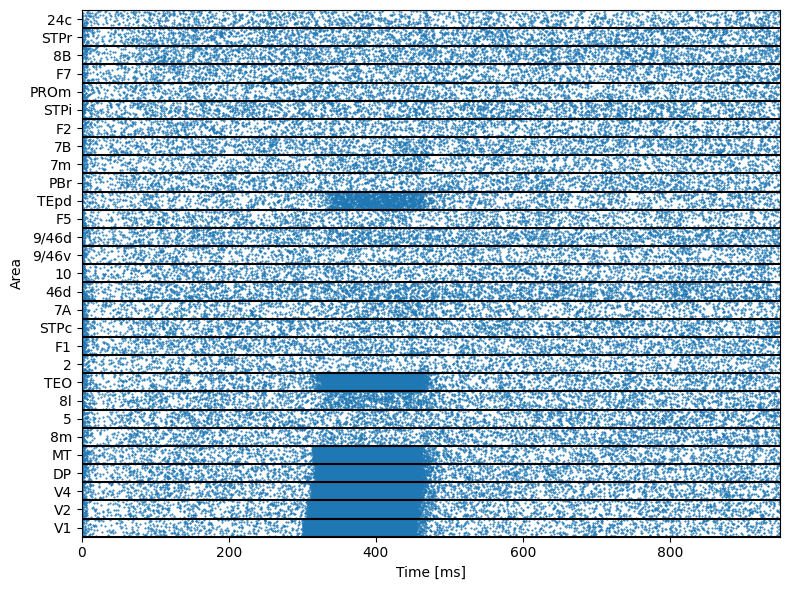

In [62]:
def raster_plot(xValues, yValues, duration):
  ticks = np.round(np.arange(0, 29) + 0.5, 2)
  areas = ['V1', 'V2', 'V4', 'DP', 'MT', '8m', '5', '8l', 'TEO', '2', 'F1',
           'STPc', '7A', '46d', '10', '9/46v', '9/46d', 'F5', 'TEpd', 'PBr',
           '7m', '7B', 'F2', 'STPi', 'PROm', 'F7', '8B', 'STPr', '24c']
  N = len(ticks)
  plt.figure(figsize=(8, 6))
  plt.plot(xValues, yValues / (4 * 400), '.', markersize=1)
  plt.plot([0, duration], np.arange(N + 1).repeat(2).reshape(-1, 2).T, 'k-')
  plt.ylabel('Area')
  plt.yticks(np.arange(N))
  plt.xlabel('Time [ms]')
  plt.ylim(0, N)
  plt.yticks(ticks, areas)
  plt.xlim(0, duration)
  plt.tight_layout()
  plt.show()

times, indices = np.where(runner.mon['E.spike'])
times = runner.mon.ts[times]
raster_plot(times, indices, length)